# [1주차] 기본 과제: MNIST 분류(Classification) 모델 구현
- MNIST Dataset을 Regression Model이 아닌, Classification Model로 구현
- train과 test data에 대한 모델의 정확도를 plot하여 Generalization Error 살펴보기


In [ ]:
# 현재 경로 확인
%pwd

'/content'

In [1]:
# torch 라이브러리 임포트
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.


In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4567066.15it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135519.76it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1269030.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10314309.02it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


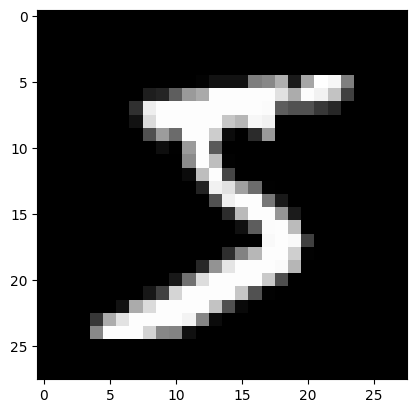

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [10]:
batch_size =256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

## 1. Test Data 준비하기
- Test data는 MNIST의 train data를 load하는 코드에서 `train=False`로 두면 됩니다.
- Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
    - Test data는 랜덤하게 섞일 필요가 없기 때문에 `shuffle=False`로 설정합니다.

In [5]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

10000
torch.Size([1, 28, 28]) 7


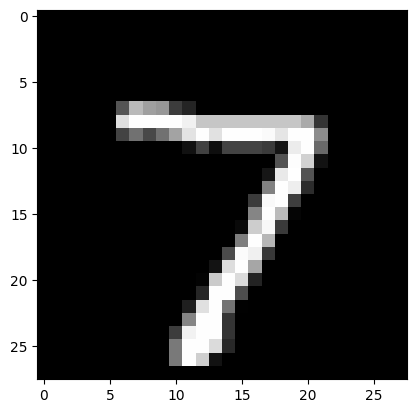

In [19]:
print(len(testset))
print(testset[0][0].shape, testset[0][1])
plt.imshow(testset[0][0][0], cmap='gray')

In [12]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


## 2. `nn.CrossEntropyLoss` 적용하기
- 현재 코드는 regression model을 구현한 상태로, MSE를 loss로 사용하고 있습니다.
- 하지만 MNIST와 같은 분류 문제에서는 MSE는 적합하지 않습니다.
  - MSE에 따르면 1에 해당하는 손글씨 이미지는 7에 해당하는 손글씨 이미지보다 0에 해당하는 손글씨 이미지가 더 가깝게 여겨집니다.
  - 하지만 1은 실제로 0보다 7과 더 비슷하게 생겼습니다.
- 일반적으로 분류 문제는 MSE 대신 cross entropy loss를 사용합니다.
- PyTorch에서의 [cross entropy loss 문서](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 또는 [웹 자료](https://uumini.tistory.com/54)들을 통해 이해한 후, MSE를 대체하는 코드를 구현하시면 됩니다.
  - 변경되어야 할 점은 2가지로 i) `Model`의 최종 output의 dimension과 ii) `loss` 계산 부분입니다.

In [14]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    ## 출력 output 레이어의 dimension 1->10으로 변경; 클래스 수(MNIST 0~10)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [15]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [22]:
n_epochs = 100
## Loss Function: MSE -> CrossEntropy
loss_fn = nn.CrossEntropyLoss()

# Accuracy를 저장할 리스트 정의
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    ## CrossEntropy 정의
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 1 epoch 당 정확도 저장
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc} | Test Acc: {test_acc}")

Epoch   0 | Loss: 195.96155774593353 | Train Acc: 0.7158166666666667 | Test Acc: 0.7145
Epoch   1 | Loss: 195.65032142400742 | Train Acc: 0.7159666666666666 | Test Acc: 0.7146
Epoch   2 | Loss: 195.13415825366974 | Train Acc: 0.71625 | Test Acc: 0.7146
Epoch   3 | Loss: 194.90265893936157 | Train Acc: 0.7166 | Test Acc: 0.7147
Epoch   4 | Loss: 194.41063570976257 | Train Acc: 0.71675 | Test Acc: 0.7152
Epoch   5 | Loss: 194.0583651661873 | Train Acc: 0.71695 | Test Acc: 0.7154
Epoch   6 | Loss: 193.89761424064636 | Train Acc: 0.71715 | Test Acc: 0.7153
Epoch   7 | Loss: 193.58984106779099 | Train Acc: 0.71735 | Test Acc: 0.7158
Epoch   8 | Loss: 193.19567573070526 | Train Acc: 0.7176833333333333 | Test Acc: 0.7161
Epoch   9 | Loss: 192.91515165567398 | Train Acc: 0.7178666666666667 | Test Acc: 0.7166
Epoch  10 | Loss: 192.48917442560196 | Train Acc: 0.7181666666666666 | Test Acc: 0.7169
Epoch  11 | Loss: 192.15685904026031 | Train Acc: 0.7185333333333334 | Test Acc: 0.7171
Epoch  12 | 

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [18]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[1.8477, 0.0000, 0.0000, 4.3290, 0.0000, 4.1756, 0.0000, 0.0000, 0.3499,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
5


## 3. 학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기
- 다음 조건들 아래에서 학습을 진행하면 됩니다.
  - `n_epochs`=100, `batch_size`=256, `lr`=0.001.
- 어떤 dataloader에 대한 model의 정확도를 측정하는 코드는 다음 함수를 사용하시면 됩니다:

In [21]:
import numpy as np

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [23]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

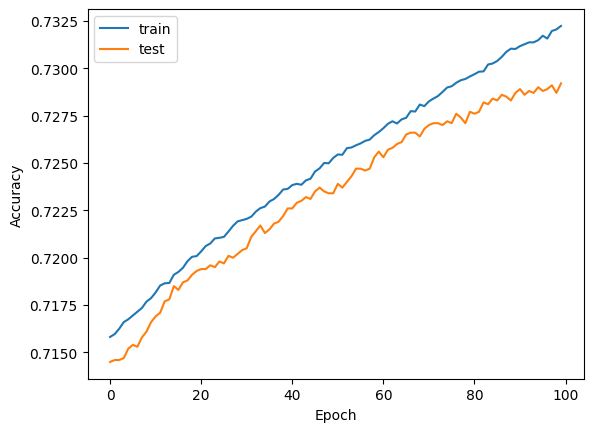

In [24]:
plot_acc(train_accs, test_accs)